# CS 4641 Midterm Checkpoint

**Problem**: Predicting odds of winning a chess game based on several factors, primarily opening strategy.

**Plan**: Create visualizations and perform dimensionality reduction on the dataset to determine the best features for Linear Regression. 
1. Prediction based on Opening Move Names and other features
2. Prediction based on Dataset reduced with PCA 

Also possibly:
- Comparing basic Linear Regression to Ridge/Lasso Regression


---

## Uploading the Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('data/high_elo_opening.csv')
df.head()

,opening_name,side,num_games,ECO,last_played_date,perf_rating,avg_player,perc_player_win,perc_draw,pec_opponent_win,...,move2b,move3w,move3b,move4w,move4b,perc_white_win,perc_black_win,white_odds,white_wins,black_wins
0,"Alekhine Defense, Balogh Variation",white,692,B03,2018-06-22,2247,2225,40.8,24.3,35.0,...,Nd5,d4,d6,Bc4,NaN,40.8,35.0,1.165714,282.336,242.200
1,"Alekhine Defense, Brooklyn Variation",black,228,B02,2018-06-27,2145,2193,29.8,22.4,47.8,...,Ng8,NaN,NaN,NaN,NaN,47.8,29.8,1.604027,108.984,67.944
2,"Alekhine Defense, Exchange Variation",white,6485,B03,2018-07-06,2244,2194,40.8,27.7,31.5,...,Nd5,d4,d6,c4,Nb6,40.8,31.5,1.295238,2645.880,2042.775
3,"Alekhine Defense, Four Pawns Attack",white,881,B03,2018-06-20,2187,2130,39.7,23.2,37.1,...,Nd5,d4,d6,c4,Nb6,39.7,37.1,1.070081,349.757,326.851
4,"Alekhine Defense, Four Pawns Attack, Fianchett...",black,259,B03,2018-05-20,2122,2178,37.8,21.2,40.9,...,Nd5,d4,d6,c4,Nb6,40.9,37.8,1.082011,105.931,97.902


---

## Preprocessing

In [4]:
df.rename(columns={'pec_opponent_win':'perc_opponent_win'}, inplace=True)

# Basic manual dimensionality reduction: remove 'last_date_played', moves
df.drop(['last_played_date', 'moves_list', 'move1w', 'move1b', 'move2w', 'move2b', 'move3w', 'move3b', 'move4w', 'move4b'], axis=1, inplace=True)

**Feature Encoding:** Must encode non-numerical features like opening_name, ECO so they can be visualized in correlation matrix and used in ML models.

In [5]:
# Copy dataframe to compare # unique values in different features (preserve original opening names)
df2 = df.copy()


df['opening_name'] = df['opening_name'].str.split(',').str[0]

# Since there are ~90 unique values for opening_name, we use label encoder instead of one-hot
label_encoder = preprocessing.LabelEncoder()
df['opening_name'] = label_encoder.fit_transform(df['opening_name'])

label_encoder_ECO = preprocessing.LabelEncoder()
df['ECO'] = label_encoder_ECO.fit_transform(df['ECO'])

# one-hot encoding for 'side' (white/black)
df = pd.get_dummies(df, columns=['side'])

df.head()

,opening_name,num_games,ECO,perf_rating,avg_player,perc_player_win,perc_draw,perc_opponent_win,perc_white_win,perc_black_win,white_odds,white_wins,black_wins,side_black,side_white
0,0,692,103,2247,2225,40.8,24.3,35.0,40.8,35.0,1.165714,282.336,242.200,False,True
1,0,228,102,2145,2193,29.8,22.4,47.8,47.8,29.8,1.604027,108.984,67.944,True,False
2,0,6485,103,2244,2194,40.8,27.7,31.5,40.8,31.5,1.295238,2645.880,2042.775,False,True
3,0,881,103,2187,2130,39.7,23.2,37.1,39.7,37.1,1.070081,349.757,326.851,False,True
4,0,259,103,2122,2178,37.8,21.2,40.9,40.9,37.8,1.082011,105.931,97.902,True,False


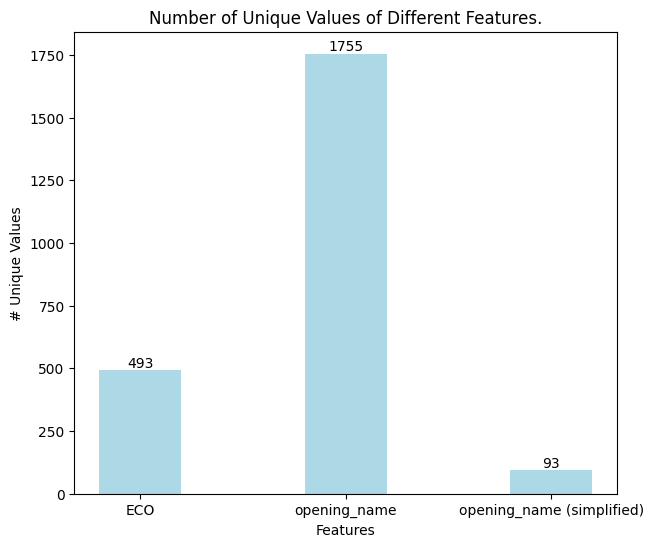

In [6]:
# Plot the number of unique values in columns that identify opening moves/strategies
num_ECO = df['ECO'].nunique()
num_openings = df2['opening_name'].nunique()
num_openings_simp = df['opening_name'].nunique()

plt.figure(figsize=(7, 6))
plt.title("Number of Unique Values of Different Features.")

bar = plt.bar(['ECO', 'opening_name', 'opening_name (simplified)'], [num_ECO, num_openings, num_openings_simp], color ='lightblue', width = 0.4)

plt.xlabel("Features")
plt.ylabel("# Unique Values")
plt.bar_label(bar)
plt.show()

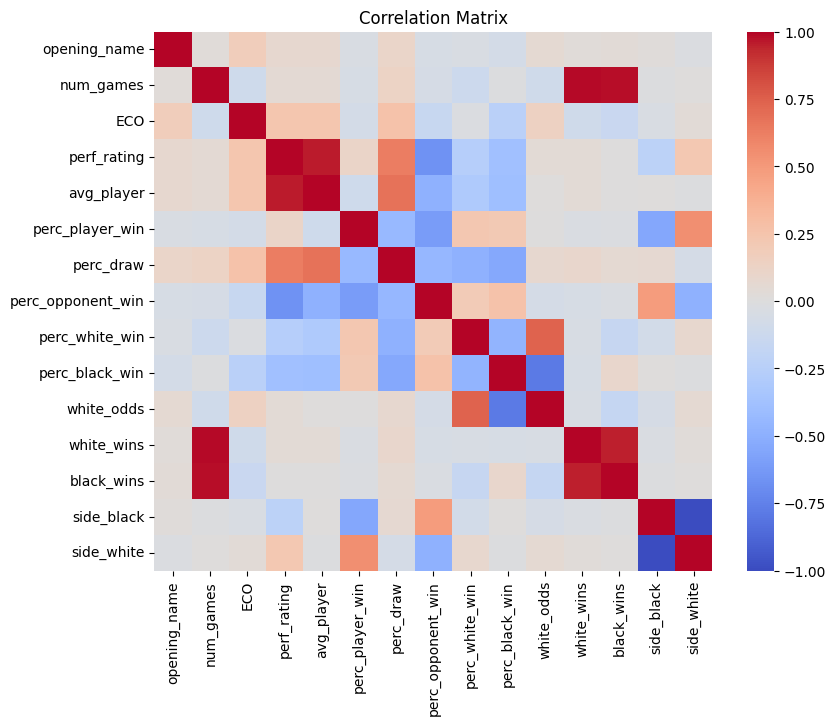

In [7]:
# Correlation matrix to show which variables most correlated to game win pct
matrix = df.corr()

plt.figure(figsize=(9,7))
plt.title("Correlation Matrix")
sns.heatmap(matrix, cmap="coolwarm", annot=False)
plt.show()

While there are no obvious linear relationships between any variables and opening_name or perc_player_win, this can help us determine which values might be redundant (if they are highly correlated)

**Manual Dimensionality Reduction:** Start by manually removing features that are redundant or unlikely to contribute to model outcomes.

In [8]:
df.drop(['ECO', 'num_games', 'perc_opponent_win', 'perc_draw', 'perc_white_win', 'perc_black_win', 'white_odds', 'white_wins', 'black_wins'], axis=1, inplace=True)
print(df.columns)

Index(['opening_name', 'perf_rating', 'avg_player', 'perc_player_win',
       'side_black', 'side_white'],
      dtype='object')


**PCA:** Apply dimensionality reduction algorithm to identify most important features and further reduce the number of features.

In [502]:
# TO DO: implement PCA on either the manually reduced dataset (df), or the original dataset by making a copy at the beginning.
# Then we can compare how the Linear Regression performs with the reduced vs unreduced dataset
#       Note: if we want to visualize data better, maybe reduce to 2 Ind. Var. (don't forget to separate labels first)




---

## Machine Learning Model

In [9]:
X = df.drop('perc_player_win', axis=1)
y = df['perc_player_win']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Cross Validation**: Perform KFold Cross Validation to determine the generalizability of the LinearRegression model.

In [11]:
model = LinearRegression()

kfolds = KFold(n_splits=10)
scores = cross_val_score(model, X_train, y_train, cv=kfolds)
print("R2 at each fold: " + str(scores))
print("Mean R2: " + str(scores.mean()))

R2 at each fold: [0.46186869 0.51100855 0.52868991 0.55638487 0.56936324 0.50832867
 0.57660609 0.55252631 0.55799647 0.63742521]
Mean R2: 0.54601980151325


In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**For dataset reduced with PCA**

**Note:** *If we performed PCA, we could train a separate model using that reduced dataframe, and then we can compare the results of regression when using manual dim. reduction vs PCA*

In [ ]:
# TO DO (maybe): do the same trianing as before but with df2, a separate dataframe that is trained with PCA-reduced data.




---

## Evaluation Metrics

**MSE and R²:** Determine how

In [13]:
y_pred = model.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: " + str(mse))
print("R2: " + str(r2))

MSE: 37.31489093922182
R2: 0.49412728973164355


**Actual vs Predicted:** Compare actual values from y_test to predicted values y_pred.

In [ ]:
# To Do: Make a matplotlib scatter plot comparing actual values to predicted ones. (Perfect result would be a diagonal line of points)




Whatever other visualizations we can do for dataset with more than 2 independent variables

**For dataset reduced with PCA**

**Note:** *If we performed PCA, we could do some of the same evaluation metrics for the outcomes of the separate Regression model.*

In [ ]:
# TO DO: Find MSE, R2, and whatever visualizations for the regression model trained on PCA-reduced data


